**Steps**

1. Install and load libraries and packages.


In [ ]:
#If you receive an error running this cell for the first time, try running it agian. 

import csv
import warnings
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from tqdm import tqdm

from time import sleep
from pybliometrics.scopus import CitationOverview, AuthorRetrieval, AbstractRetrieval
# from pybliometrics.scopus.utils import config
# config['Authentication'] ['APIKey'] = <<API KEY HERE>>

: 

2. Modify the names of the input and output files. The name of the input file should match the name of the author list CSV file. If you followed the setup instructions, the CSV file should now be in the same directory as this notebook file. The output file does not have to exist yet (it will be created). 

In [7]:
# !!! Modify this to match the name of your author list CSV file. 
author_list_csv = "sv_authorlist.csv"
output_data_csv = "sv_ss_output_data.csv"

#data stored in csv columns
lastname_col = 0 
firstname_col = 1
id_col = 2 

3. Load in the author names from the CSV file. 

In [8]:
# author_rows= []
# with open(author_list_csv, encoding ="utf-8-sig") as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter =',')
#     for row in csv_reader:
#         if row[0] != "":
#             author_rows.append(row)

# author_rows = author_rows[1:]

# print("first row:", author_rows[0])
# try:
#     author_names = [row for row in author_rows if row[id_col] != "" and int(row[id_col])]
# except ValueError:
#     raise ValueError("make sure the index of the column ID from member array is valid!")

authorlist_df = pd.read_csv(author_list_csv)

4. Modify the affiliations list with institutions which the researchers are affiliated with. 

In [9]:
affiliations = ['University of British Columbia', 'UBC', 'Djavad Mowafaghian', 'Simon Fraser University', 'University of Victoria', 'University of Washington']

5. Scrape data for each author. This will take several minutes. 

In [10]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for idx, athr in authorlist_df.iterrows():
    sleep(1)
    used_athr_ID = False
    scopus_id = str(int(athr['Author ID']))
    pubs = []
    try :
        ar = AuthorRetrieval(scopus_id)
        documents = ar.get_documents()
        author_name = athr["Name"]
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': author_name, 'Warning': 'no information found'}
    else:
        # Get publications titles 
        for document in documents:
            pubs.append(document.title)
            
            # Add to dictionary with title as key and author as value
            if (document.title not in pub_authors.keys()) or (author_name not in pub_authors[document.title]): 
                pub_authors.setdefault(document.title, []).append(author_name)

        
        row = {'Name': author_name, 
               'Author ID': scopus_id,
               'Cited by': ar.citation_count,
            #    'Publications': pubs,
               'Document Count': ar.document_count,
               'Affiliation':ar.affiliation_current[0].preferred_name}
        
        # Create list of authors who do not have the specified affiliation

        if used_athr_ID == False and not any(ar.affiliation_current[0].preferred_name):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)
        used_athr_ID = False
                

6. Add coauthors to the rows. 

In [11]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]

        

In [12]:
coauthored_pubs = [
    title
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_authors = [
    authors
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_df = pd.DataFrame({"Title": coauthored_pubs, "Authors": coauthored_authors})

print(coauthored_df.head())

coauthored_df.to_csv("sv_shared_pubs.csv",index=False)

                                               Title  \
0  Chronic multiscale resolution of mouse brain n...   
1  Water-Reaching Platform for Longitudinal Asses...   
2  Multiscale imaging informs translational mouse...   
3  Towards a Visualizable, De-identified Syntheti...   
4  Altered cortical processing of sensory input i...   

                          Authors  
0   [Tim H. Murphy, Lynn Raymond]  
1   [Tim H. Murphy, Lynn Raymond]  
2  [Tim H. Murphy, Jeffrey LeDue]  
3   [Tim H. Murphy, Helge Rhodin]  
4   [Tim H. Murphy, Lynn Raymond]  


7. Write rows to output CSV file

In [1]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
# keys = ['Name', 'Scholar ID', 'Document Count', 'Cited by', 'Cited by 5 years', 'h-index', 'h-index 5 years',  'i10-index', 'i10-index 5 years', 'Publications', 'Coauthors', 'Affiliation', 'Warning']
keys = ['Name', 
        'Author ID',
        'Cited by',
        'Document Count',
        # 'Publications',
        'Coauthors',
        'Affiliation']

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data_csv, mode='w', encoding ="utf-8", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)

NameError: name 'output_data_csv' is not defined

8. Create barplot of citations per year. Modify the years and output PDF filename. 

In [60]:
# # Create citations per year dataframe
# cites_df = pd.DataFrame(cites_per_year)

# # Add a totals column
# cites_df.loc['Total']= cites_df.sum()

# # Select years to plot
# cites_df_selected = cites_df[[2018,2019,2020,2021,2022,2023]]

# # Select the last row (totals) 
# cites_df_total = cites_df_selected.iloc[-1:]

# # Create barplot
# years = list(cites_df_total.columns)
# cites = cites_df_total.values.tolist()[0]
# plt.bar(years, cites )
# plt.ylabel('Total Citations')

# # !!! Modify this - name the output PDF file
# # plt.savefig(bargraph_output)
# plt.savefig("sv_bargraph.csv")

9. Create collaboration heatmap

['Tim H. Murphy', 'Lynn Raymond', 'Jeffrey LeDue', 'Helge Rhodin', 'Brian MacVicar', 'Yu Tian Wang', 'Wolfram Tetzlaff', 'Craig E. Brown', 'Andy Shih', 'Terry Snutch', 'Silke Cresswell', 'Leigh Anne Swayne', 'Shernaz Bamji', 'Anthony Phillips', 'Fidel Vila-Rodriguez', 'Sophia Frangou', 'Ian Mackenzie', 'Jason Snyder', 'Z. Jane Wang', 'Kurt Haas', 'Paul Pavlidis', 'Catharine Rankin', 'Lara Boyd', 'Liisa Galea', 'Martin McKeown', 'A Jon Stoessl', 'Vesna Sossi', 'Todd Woodward', 'Peyman Servati', 'Peter Cripton', 'Jane Roskams', 'Fabio Rossi', 'Jeremy Seamans', 'Catharine Winstanley', 'Leonid Sigal', 'Brian D. Fisher', 'Purang Abolmaesumi', 'Adrienne Fairhall', 'Eric Shea-Brown', 'Ilker Hacihaliloglu']


c:\Users\caoyut\.conda\envs\sms\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


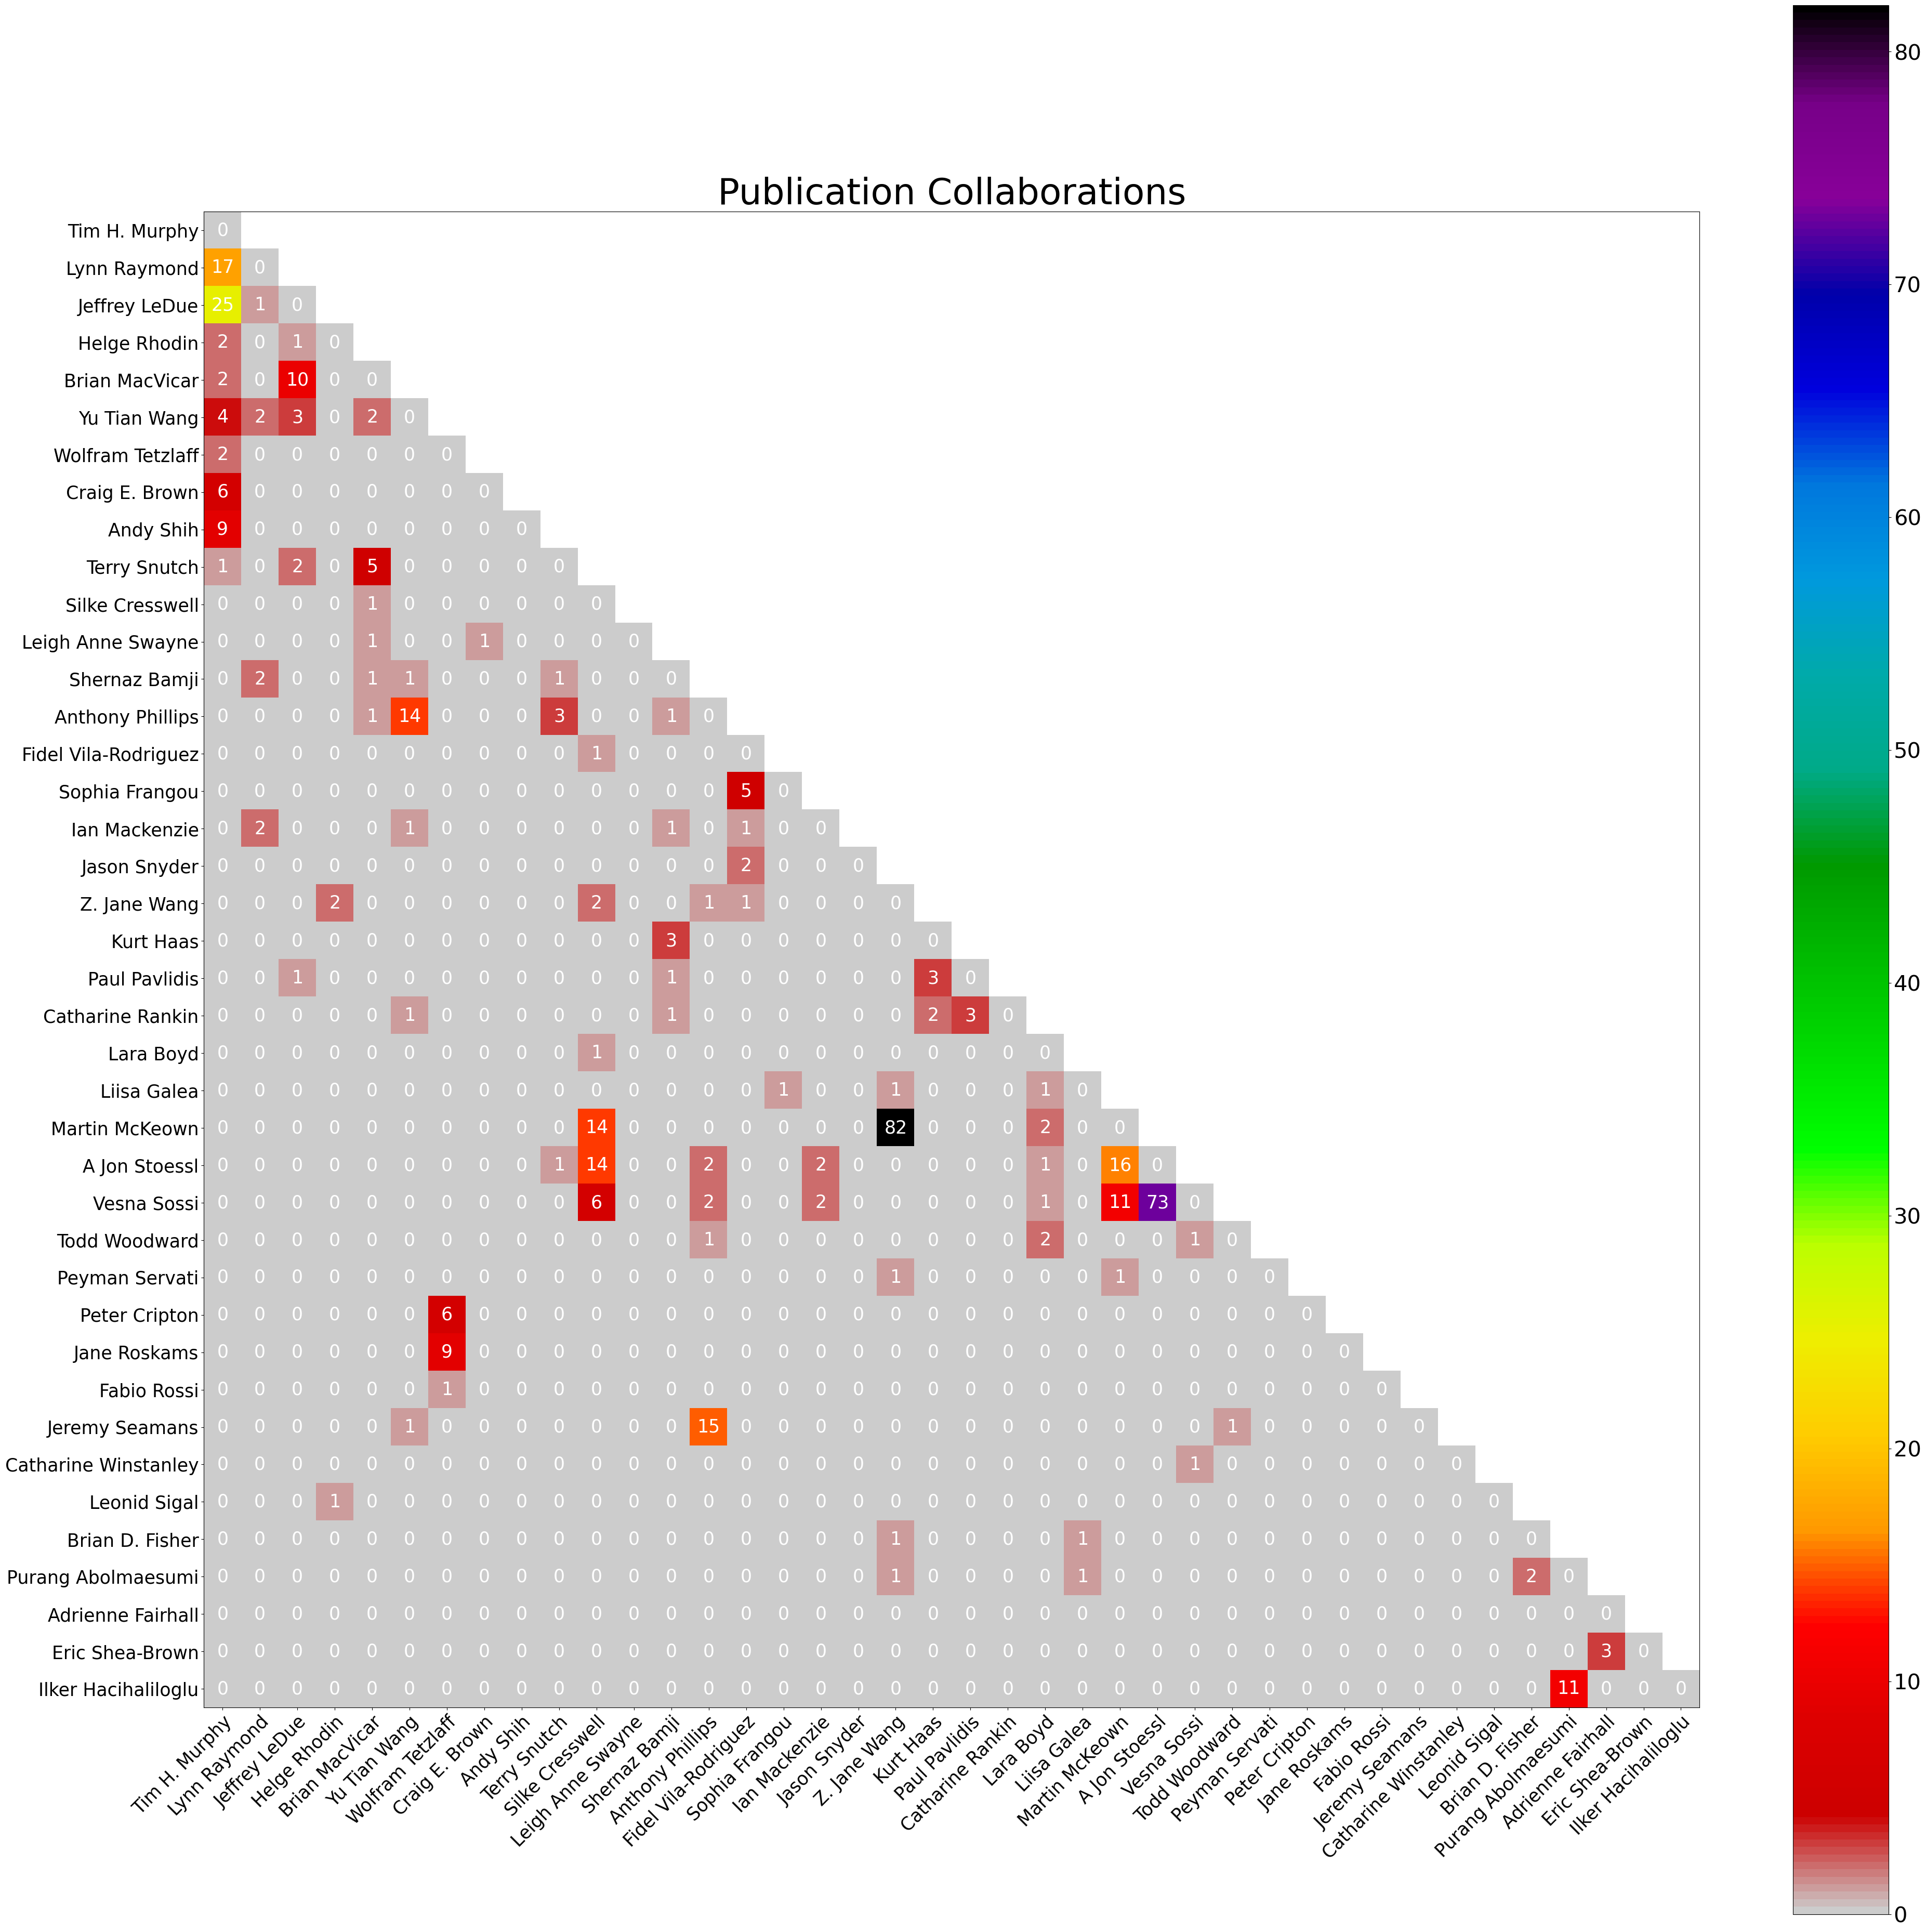

In [14]:
authors = list(collabs_dict.keys())
print(authors)
author_count=len(authors)
# Initialize array with zeros. 
collabs_array = np.zeros((author_count, author_count), dtype=int)

# Populate the array with the number of collaborations between authors
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]
            
# Only display the lower triangle of the matrix
mask =  np.tri(collabs_array.shape[0], k=-1)
collabs_array = np.ma.array(collabs_array, mask=mask).T

# Set up the colourmap 
cmap = plt.colormaps['nipy_spectral']
cmap = cmap.reversed()

### Create heatmap ###

fig = plt.figure(figsize = (author_count,author_count)) 
ax = fig.add_subplot(111)
im = ax.imshow(collabs_array, cmap=cmap, interpolation='nearest', 
               #norm=matplotlib.colors.LogNorm()            # Uncomment this if you want a logarithmic colormap
              )

# Show the ticks
ax.set_xticks(np.arange(author_count))
ax.set_yticks(np.arange(author_count))

# Label the ticks with author names - you can modify the authorname font size here
ax.set_xticklabels(authors,fontsize=25)
ax.set_yticklabels(authors, fontsize=25)

# Rotate and align tick labels.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create numeric annotations.
for i in range(author_count):
    for j in range(author_count):
        text = ax.text(j, i, collabs_array[i, j],
                       ha="center", va="center", color="w", fontsize=25)
# Fit plot within figure        
fig.tight_layout()


# Add title - you can change the title and title font size here
ax.set_title("Publication Collaborations", fontsize = 50)

# Add the colorbar and add ticks - change colorbar label fontsize here
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=30)

# Save the figure as PDF - you can modify the filename here. 
# plt.savefig(figure_output)
plt.savefig("sv_heatmap1.pdf")

plt.show()
